In [1]:
import pandas as pd
import numpy as np
import plotly as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import tree

pio.renderers.default = "browser"

<h3> Load the data from source </h3>

In [12]:
# pull shot data - note that this is from github - https://github.com/sealneaward/nba-movement-data

raw = pd.read_csv('NBA-Shot-Prediction\data\shots_fixed.csv')
dropped = raw.drop(columns = ['EVENT_TYPE', 'GAME_EVENT_ID', 'GAME_DATE', 'GAME_ID'])

dropped.head(10)

,ACTION_TYPE,EVENTTIME,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,PLAYER_ID,PLAYER_NAME,...,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Jump Shot,215,Shot Chart Detail,LAL,-23.9825,157.0968,3,1,101138,Brandon Bass,...,15,0,218.50,2PT Field Goal,Center(C),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
1,Dunk Shot,191,Shot Chart Detail,LAL,224.3221,24.9662,3,1,101138,Brandon Bass,...,0,1,204.83,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
2,Jump Shot,518,Shot Chart Detail,LAL,-5.4122,173.0601,8,2,101138,Brandon Bass,...,16,1,520.65,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,OKC
3,Jump Shot,120,Shot Chart Detail,LAL,-25.9351,158.7570,2,3,101138,Brandon Bass,...,15,0,123.26,2PT Field Goal,Center(C),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
4,Jump Shot,646,Shot Chart Detail,LAL,178.3350,20.1712,10,1,201579,Roy Hibbert,...,15,1,650.49,2PT Field Goal,Right Side(R),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
5,Hook Shot,552,Shot Chart Detail,LAL,100.3073,98.9265,9,1,201579,Roy Hibbert,...,5,0,546.23,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
6,Hook Shot,430,Shot Chart Detail,LAL,111.9160,222.6307,7,1,201579,Roy Hibbert,...,4,0,449.90,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
7,Hook Shot,590,Shot Chart Detail,LAL,-92.6563,65.3523,9,3,201579,Roy Hibbert,...,5,0,593.22,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC
8,Jump Shot,401,Shot Chart Detail,LAL,-216.1135,-10.5376,6,1,1626204,Larry Nance Jr.,...,13,1,408.84,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,OKC
9,Layup Shot,273,Shot Chart Detail,LAL,-219.9258,16.3056,4,2,1626204,Larry Nance Jr.,...,1,0,297.98,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,OKC


Get the shots grouped by player in a dictionary

<h3> Compute the shooting average for each player </h3>

In [4]:

playerDict = {} # first is player name, second is their shots

# get list of ids
playerIds = dropped.PLAYER_ID.unique()

# make dictionary with empty arrays for each player's shots
for pid in playerIds:
    playerDict[pid] = []

# for each shot, add it to the player ID's array
for index, row in dropped.iterrows():
    innerPid = row['PLAYER_ID']
    shotMade = row['SHOT_MADE_FLAG']
    
    playerDict[innerPid].append(shotMade)

In [5]:
# try 2
playerAvgGrouped = dropped.groupby('PLAYER_ID', as_index=False)['SHOT_MADE_FLAG'].mean()
playerAverages = playerAvgGrouped.set_index(playerAvgGrouped['PLAYER_ID'])

In [ ]:
shotAvgDict = {}

# get average of python list
def avg(l): 
    return sum(l) / len(l) 

for p in playerDict.keys():
    shotAvgDict[p] = avg(playerDict[p])
    
shotAvgDict

In [8]:
# copy
full = dropped.sample(frac = 1)
full['PLAYER_AVG'] = ''

# add average -> This takes a bit for me. About 9 mins on my machine
# Will go to OH to try to speed it up, but until then, we can just use the outputted CSV 
for index, row in full.iterrows():
    full.loc[full['PLAYER_ID'] == row['PLAYER_ID'], 'PLAYER_AVG'] = shotAvgDict[row['PLAYER_ID']]

<h4> Load to csv so we don't have to rerun this every time </h4>

In [9]:
full.to_csv('fullDF.csv')

<h2> Data Analysis and ML </h2>

<h4> Get full csv </h4>

In [2]:
fullDF = pd.read_csv('fullDF.csv')

<h4> Drop irrelevant columns</h4>

In [3]:
# drop irrelevant columns
fullDF = fullDF.loc[:, ~fullDF.columns.str.contains('^Unnamed')]
fullDF.drop(columns = ['EVENTTIME', 'GRID_TYPE', 'PLAYER_ID', 'SHOT_ATTEMPTED_FLAG', 'TEAM_ID'], inplace = True)

<h4> Use entropy to find which columns to drop </h4>

First one hot encode and break into preliminary testing and training data

Now see likelihood of making a shot based on different correlations (this takes about 2 minutes on my machine)

In [6]:
# try with everything
categorical_cols = ['ACTION_TYPE', 'HTM', 'PERIOD', 'PLAYER_NAME', 'QUARTER', 'SHOT_TYPE', 'SHOT_ZONE_AREA',
                    'SHOT_ZONE_BASIC', 'SHOT_ZONE_RANGE', 'TEAM_NAME', 'VTM']

def onehot_encode(data):
    for feature in categorical_cols:
        one_hot = pd.get_dummies(data[feature], prefix=feature)
        data = data.drop(feature, axis = 1)
        data = data.join(one_hot)
    return data

featPrelim = onehot_encode(fullDF)
featPrelim

,LOC_X,LOC_Y,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TIME,PLAYER_AVG,ACTION_TYPE_Alley Oop Dunk Shot,ACTION_TYPE_Alley Oop Layup shot,...,VTM_OKC,VTM_ORL,VTM_PHI,VTM_PHX,VTM_POR,VTM_SAC,VTM_SAS,VTM_TOR,VTM_UTA,VTM_WAS
0,-24.4707,247.1845,5,23,27,1,340.26,0.413866,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-191.5255,46.5311,8,46,20,0,529.69,0.443878,0,0,...,0,0,0,0,0,0,0,1,0,0
2,225.7301,13.3043,5,29,23,0,334.46,0.491150,0,0,...,0,0,0,0,0,0,0,0,0,0
3,165.3055,209.6866,5,10,2,1,297.32,0.375527,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-43.0428,264.6146,5,14,26,0,317.28,0.376812,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84462,-53.7916,131.7924,5,50,17,0,353.07,0.472906,0,0,...,0,0,0,1,0,0,0,0,0,0
84463,-222.2937,3.2989,11,2,17,0,657.95,0.474359,0,0,...,0,0,0,0,0,0,0,0,0,0
84464,54.9737,69.6666,0,0,1,1,1.74,0.451327,0,0,...,0,0,0,0,0,0,0,0,0,0
84465,83.8071,39.1078,5,42,9,0,344.74,0.437751,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
correlation_df = featPrelim.corr()[['SHOT_MADE_FLAG']]
correlation_df.rename(columns={"SHOT_MADE_FLAG": "correlation_with_making_shot"}, inplace=True)
correlation_df

,correlation_with_making_shot
LOC_X,0.007481
LOC_Y,-0.036743
MINUTES_REMAINING,0.011510
SECONDS_REMAINING,0.010951
SHOT_DISTANCE,-0.187651
...,...
VTM_SAC,0.004892
VTM_SAS,0.003040
VTM_TOR,-0.004145
VTM_UTA,0.000401


Check for features that have a correlation above 0.03

In [8]:
relevant_cols = correlation_df.loc[correlation_df['correlation_with_making_shot'] >= 0.03]
relevant_cols

,correlation_with_making_shot
SHOT_MADE_FLAG,1.000000
PLAYER_AVG,0.120922
ACTION_TYPE_Alley Oop Dunk Shot,0.074933
ACTION_TYPE_Cutting Dunk Shot,0.082773
ACTION_TYPE_Cutting Finger Roll Layup Shot,0.038050
ACTION_TYPE_Cutting Layup Shot,0.085503
ACTION_TYPE_Driving Dunk Shot,0.072543
ACTION_TYPE_Driving Finger Roll Layup Shot,0.060802
ACTION_TYPE_Driving Layup Shot,0.076853
ACTION_TYPE_Dunk Shot,0.108120


From this, we gather that the most important features are the player's average, shot zone, shot distance, location, and action/shot type

In [9]:
dataset_imp_features_only = fullDF[['SHOT_MADE_FLAG', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE',
                                    'PLAYER_AVG', 'SHOT_TYPE', 'ACTION_TYPE', 'SHOT_DISTANCE', 'LOC_Y', 'LOC_X']]
dataset_imp_features_only

,SHOT_MADE_FLAG,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,PLAYER_AVG,SHOT_TYPE,ACTION_TYPE,SHOT_DISTANCE,LOC_Y,LOC_X
0,1,Above the Break 3,Center(C),24+ ft.,0.413866,3PT Field Goal,Jump Shot,27,247.1845,-24.4707
1,0,Mid-Range,Left Side(L),16-24 ft.,0.443878,2PT Field Goal,Jump Shot,20,46.5311,-191.5255
2,0,Right Corner 3,Right Side(R),24+ ft.,0.491150,3PT Field Goal,Jump Shot,23,13.3043,225.7301
3,1,Restricted Area,Center(C),Less Than 8 ft.,0.375527,2PT Field Goal,Layup Shot,2,209.6866,165.3055
4,0,Above the Break 3,Left Side Center(LC),24+ ft.,0.376812,3PT Field Goal,Jump Shot,26,264.6146,-43.0428
...,...,...,...,...,...,...,...,...,...,...
84462,0,Mid-Range,Left Side Center(LC),16-24 ft.,0.472906,2PT Field Goal,Jump Shot,17,131.7924,-53.7916
84463,0,Mid-Range,Right Side(R),16-24 ft.,0.474359,2PT Field Goal,Jump Shot,17,3.2989,-222.2937
84464,1,Restricted Area,Center(C),Less Than 8 ft.,0.451327,2PT Field Goal,Driving Layup Shot,1,69.6666,54.9737
84465,0,Mid-Range,Right Side(R),8-16 ft.,0.437751,2PT Field Goal,Turnaround Bank shot,9,39.1078,83.8071


One hot encode again, but only on the important features

In [10]:
categorical_cols = ['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'PLAYER_AVG', 'SHOT_TYPE', 'ACTION_TYPE']

def onehot_encode(data):
    for feature in categorical_cols:
        one_hot = pd.get_dummies(data[feature], prefix=feature)
        data = data.drop(feature, axis = 1)
        data = data.join(one_hot)
    return data

important_features_df = onehot_encode(dataset_imp_features_only)
important_features_df

,SHOT_MADE_FLAG,SHOT_DISTANCE,LOC_Y,LOC_X,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_Backcourt,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,...,ACTION_TYPE_Step Back Bank Jump Shot,ACTION_TYPE_Step Back Jump shot,ACTION_TYPE_Tip Dunk Shot,ACTION_TYPE_Tip Layup Shot,ACTION_TYPE_Turnaround Bank Hook Shot,ACTION_TYPE_Turnaround Bank shot,ACTION_TYPE_Turnaround Fadeaway Bank Jump Shot,ACTION_TYPE_Turnaround Fadeaway shot,ACTION_TYPE_Turnaround Hook Shot,ACTION_TYPE_Turnaround Jump Shot
0,1,27,247.1845,-24.4707,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,20,46.5311,-191.5255,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,23,13.3043,225.7301,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,209.6866,165.3055,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,26,264.6146,-43.0428,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84462,0,17,131.7924,-53.7916,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
84463,0,17,3.2989,-222.2937,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
84464,1,1,69.6666,54.9737,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84465,0,9,39.1078,83.8071,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


<h4> Data Exploration and graphs </h4>

In [14]:
smallSamp = dropped.loc[dropped['PLAYER_ID'] == 201939]
medSamp = dropped.sample(3000)

In [43]:
fig = px.scatter(medSamp, x='LOC_X',  y='LOC_Y', color = 'SHOT_MADE_FLAG')
fig.show()

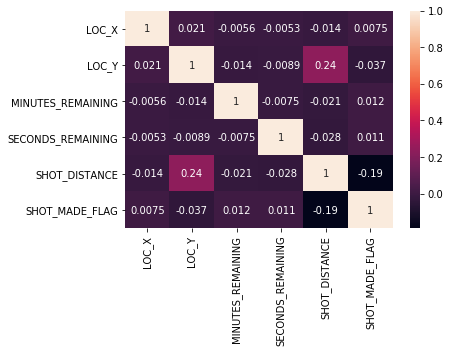

In [343]:
droppedImportant = dropped.drop(columns = ['EVENTTIME', 'PERIOD', 'QUARTER', 'SHOT_ATTEMPTED_FLAG', 'PLAYER_ID', 'TEAM_ID', 'SHOT_TIME'])
cm = droppedImportant.corr()
sn.heatmap(cm, annot=True)
plt.show()

<h4> Separate target and features</h4>

In [52]:
# try with everything
categorical_cols = ['ACTION_TYPE', 'HTM', 'PERIOD', 'PLAYER_NAME', 'QUARTER', 'SHOT_TYPE', 'SHOT_ZONE_AREA',
                    'SHOT_ZONE_BASIC', 'SHOT_ZONE_RANGE', 'TEAM_NAME', 'VTM']

def onehot_encode(data):
    for feature in categorical_cols:
        one_hot = pd.get_dummies(data[feature], prefix=feature)
        data = data.drop(feature, axis = 1)
        data = data.join(one_hot)
    return data

fullDFOHE = onehot_encode(fullDF)

target = fullDFOHE['SHOT_MADE_FLAG']
features = fullDFOHE.drop(columns = ['SHOT_MADE_FLAG'])

sample = fullDFOHE.sample(20000, random_state = 4400)
targetSmall = sample['SHOT_MADE_FLAG']
featuresSmall = sample.drop(columns = ['SHOT_MADE_FLAG'])

# check to make sure that we have a decently representative sample
print("Sample percentage made", sum(targetSmall)/len(targetSmall))
print("Actual percentage made:", sum(fullDF['SHOT_MADE_FLAG']/len(fullDF['SHOT_MADE_FLAG'])))

Sample percentage made 0.44655
Actual percentage made: 0.4483052553065842


0        1
1        1
2        1
3        1
4        0
        ..
84462    0
84463    0
84464    0
84465    0
84466    0
Name: PERIOD_1, Length: 84467, dtype: uint8

In [16]:
# try with just important features
targetImp = important_features_df['SHOT_MADE_FLAG']
featuresImp = important_features_df.drop(columns = ['SHOT_MADE_FLAG'])

impFeaturesSmall = important_features_df.sample(20000, random_state = 4400)
targetImpSmall = impFeaturesSmall['SHOT_MADE_FLAG']
featuresImpSmall = impFeaturesSmall.drop(columns = ['SHOT_MADE_FLAG'])

# check to make sure that we have a decently representative sample
print("Sample percentage made", sum(targetImpSmall)/len(targetImpSmall))
print("Actual percentage made:", sum(fullDF['SHOT_MADE_FLAG']/len(fullDF['SHOT_MADE_FLAG'])))

Sample percentage made 0.44655
Actual percentage made: 0.4483052553065842


<h4> Split </h4> 

In [17]:
# split with just the important features
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(featuresImp, targetImp, test_size=0.25, random_state = 4400) 
X_train_imp_small, X_test_imp_small, y_train_imp_small, y_test_imp_small = train_test_split(featuresImpSmall, targetImpSmall, test_size=0.25, random_state = 4400) 

In [18]:
# split with everything 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state = 4400) 
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(featuresSmall, targetSmall, test_size=0.25, random_state = 4400)

In [79]:
# make classifier and fit it
decisionTree = tree.DecisionTreeClassifier(max_depth = 2, random_state = 4400)
decisionTree = decisionTree.fit(X_train, y_train)

print("Decision tree made")

# make random forest classifiers
randomForest = RandomForestClassifier(n_estimators=5, random_state=4400)
randomForest.fit(X_train, y_train)

print("Random Forest made")

# make adaboost
adaboost = AdaBoostClassifier(n_estimators=15, random_state=4400)
adaboost.fit(X_train, y_train)

print("Adaboost done")

loc = [decisionTree, randomForest, adaboost]

print("Complete")

Decision tree made
Random Forest made
Adaboost done
Complete


In [77]:
# predict the classifications

for c in loc:    
    trainPredic = c.predict(X_train)
    trainAcc = c.score(X_train, y_train)
    precisionTrain, recallTrain, fScoreTrain, supportTrain = precision_recall_fscore_support(y_train, trainPredic)
    testPredic = c.predict(X_test)
    testAcc = c.score(X_test, y_test)
    precisionTest, recallTest, fScoreTest, supportTest = precision_recall_fscore_support(y_test, testPredic)
    
    print("\n-------------------------------------------------\n Estimator: %s" % (c))
    print("Train accuracy: %s" %  (trainAcc))
    print("Precision for training: %s" % (precisionTrain[0]))
    print("Recall for training: %s" % (recallTrain[0]))
    print("F1 for training: %s" % (fScoreTrain[0]))
    print("\n-------------------------------------------------\n")
    print("Test accuracy: %s" % (testAcc))
    print("Precision for testing: %s" % (precisionTest[0]))
    print("Recall for testing: %s" % (recallTest[0]))
    print("F1 for testing: %s" % (fScoreTest[0]))


-------------------------------------------------
 Estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=4400, splitter='best')
Train accuracy: 0.6193843725335438
Precision for training: 0.6759561414958882
Recall for training: 0.5935923888124713
F1 for training: 0.6321025328043943

-------------------------------------------------

Test accuracy: 0.6240943315811905
Precision for testing: 0.68267365153279
Recall for testing: 0.6012474367737526
F1 for testing: 0.6393785208068327

-------------------------------------------------
 Estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       

In [82]:
def adaBoostOptimizer(loEst, xtr, ytr, xte, yte):
    testAccDict = {}
    
    for i in loEst:
        # make adaboost
        adaboost = AdaBoostClassifier(n_estimators = i, random_state=4400)
        adaboost.fit(xtr, ytr)
        adaboost.predict(xte)
        testAcc = adaboost.score(xte, yte)
        testAccDict[i] = testAcc
        print("Test acc for %s: %s" % (i, testAcc))
    
    return testAccDict

In [87]:
# this is for just the important features
loValsSpec = range(1,51)
adaDictSpecSmall = adaBoostOptimizer(loValsSpec, X_train_imp_small, y_train_imp_small, X_test_imp_small, y_test_imp_small)

Test acc for 1: 0.6186
Test acc for 2: 0.6186
Test acc for 3: 0.6358
Test acc for 4: 0.6354
Test acc for 5: 0.6354
Test acc for 6: 0.6374
Test acc for 7: 0.6374
Test acc for 8: 0.6376
Test acc for 9: 0.6376
Test acc for 10: 0.6376
Test acc for 11: 0.6376
Test acc for 12: 0.6376
Test acc for 13: 0.6376
Test acc for 14: 0.6378
Test acc for 15: 0.6378
Test acc for 16: 0.6378
Test acc for 17: 0.6378
Test acc for 18: 0.6378
Test acc for 19: 0.6378
Test acc for 20: 0.6378
Test acc for 21: 0.639
Test acc for 22: 0.6386
Test acc for 23: 0.6384
Test acc for 24: 0.6378
Test acc for 25: 0.6378
Test acc for 26: 0.6376
Test acc for 27: 0.6374
Test acc for 28: 0.637
Test acc for 29: 0.6386
Test acc for 30: 0.639
Test acc for 31: 0.6388
Test acc for 32: 0.6398
Test acc for 33: 0.6398
Test acc for 34: 0.6398
Test acc for 35: 0.639
Test acc for 36: 0.639
Test acc for 37: 0.639
Test acc for 38: 0.6388
Test acc for 39: 0.6384
Test acc for 40: 0.6384
Test acc for 41: 0.6382
Test acc for 42: 0.6378
Test ac

In [88]:
# this is for the full dataset
# this is for just the important features
loValsSpec = range(1,51)
adaDictSpec = adaBoostOptimizer(loValsSpec, X_train, y_train, X_test, y_test)

Test acc for 1: 0.6240943315811905
Test acc for 2: 0.6240469763697495
Test acc for 3: 0.6406686555855472
Test acc for 4: 0.6383008950134962
Test acc for 5: 0.6419946015058957
Test acc for 6: 0.6437467443292134
Test acc for 7: 0.6400530378368139
Test acc for 8: 0.6400530378368139
Test acc for 9: 0.6400530378368139
Test acc for 10: 0.640100393048255
Test acc for 11: 0.640100393048255
Test acc for 12: 0.6402898138940191
Test acc for 13: 0.6404318795283421
Test acc for 14: 0.6404792347397831
Test acc for 15: 0.6407160107969883
Test acc for 16: 0.6409527868541933
Test acc for 17: 0.6409054316427523
Test acc for 18: 0.6418525358715726
Test acc for 19: 0.6445991381351518
Test acc for 20: 0.6445991381351518
Test acc for 21: 0.6454041767296491
Test acc for 22: 0.6454988871525311
Test acc for 23: 0.6455935975754131
Test acc for 24: 0.6448359141923569
Test acc for 25: 0.6448359141923569
Test acc for 26: 0.6453094663067671
Test acc for 27: 0.6453094663067671
Test acc for 28: 0.6462092153241464
Tes

Plot the graph to find a peak

In [96]:
# this is the graph for the small dataframe
adaSpecDfSmall = pd.DataFrame(adaDictSpecSmall, index = range(1, 51)).T
adaSpecDfSmall["estimators"] = adaSpecDfSmall.index
adaSpecDfSmall = adaSpecDfSmall.rename(columns = {1 : "accuracy"})

In [97]:
# this is the graph for the full dataframe
adaSpecDf = pd.DataFrame(adaDictSpec, index = range(1, 51)).T
adaSpecDf["estimators"] = adaSpecDf.index
adaSpecDf = adaSpecDf.rename(columns = {1 : "accuracy"})

In [111]:
# sample dataframe graph
figAB = px.line(adaSpecDfSmall, x = 'estimators', y = 'accuracy', 
                title="AdaBoost estimators and accuracy - Sample DF")
figAB.show()

In [112]:
# full dataframe graph
figAB = px.line(adaSpecDf, x = 'estimators', y = 'accuracy', 
                title="AdaBoost estimators and accuracy - Full DF")
figAB.show()

The sample has a peak around 32 estimators, and the full dataframe has its peak accuracy around 44 to 50.

In [109]:
def getABStats(nEstList, xtr, ytr, xte, yte):
    for nEst in nEstList:
        adaboost = AdaBoostClassifier(n_estimators = nEst, random_state=4400)
        adaboost.fit(X_train, y_train)
        trainPredic = adaboost.predict(X_train)
        trainAcc = adaboost.score(X_train, y_train)
        precisionTrain, recallTrain, fScoreTrain, supportTrain = precision_recall_fscore_support(y_train, trainPredic)
        testPredic = adaboost.predict(X_test)
        testAcc = adaboost.score(X_test, y_test)
        precisionTest, recallTest, fScoreTest, supportTest = precision_recall_fscore_support(y_test, testPredic)
        print("\n-------------------------------------------------\n%s Estimators:\nTrain accuracy for %s estimators: %s" % (nEst, nEst, trainAcc))
        print("Train error for %s estimators: %s" % (nEst, 1 - trainAcc))
        print("Precision for training: %s" % (precisionTrain[0]))
        print("Recall for training: %s" % (recallTrain[0]))
        print("F1 for training: %s" % (fScoreTrain[0]))
        print("\n-------------------------------------------------\n")
        print("Test accuracy for %s estimators: %s" % (nEst, testAcc))
        print("Test error for %s estimators: %s" % (nEst, 1 - testAcc))
        print("Precision for testing: %s" % (precisionTest[0]))
        print("Recall for testing: %s" % (recallTest[0]))
        print("F1 for testing: %s" % (fScoreTest[0]))

In [110]:
getABStats([10, 25, 44, 50], X_train, y_train, X_test, y_test)


-------------------------------------------------
10 Estimators:
Train accuracy for 10 estimators: 0.6358800315706393
Train error for 10 estimators: 0.3641199684293607
Precision for training: 0.6411002695803611
Recall for training: 0.770088262265016
F1 for training: 0.699699269654876

-------------------------------------------------

Test accuracy for 10 estimators: 0.640100393048255
Test error for 10 estimators: 0.35989960695174505
Precision for testing: 0.6456765582848218
Recall for testing: 0.7770847573479153
F1 for testing: 0.7053121364870104

-------------------------------------------------
25 Estimators:
Train accuracy for 25 estimators: 0.6413259668508288
Train error for 25 estimators: 0.35867403314917123
Precision for training: 0.6390360895386021
Recall for training: 0.80172512608895
F1 for training: 0.711195281915705

-------------------------------------------------

Test accuracy for 25 estimators: 0.6448359141923569
Test error for 25 estimators: 0.35516408580764314
Preci

This did best with 50 estimators. Let's see how we did based on where the player is shooting.

In [90]:
# adaboost with 50 estimators
adaboost = AdaBoostClassifier(n_estimators = 50, random_state=4400)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=4400)

In [116]:
# i checked this error and we were fine in this cell, get rid of the warning and put it back when we are done
pd.options.mode.chained_assignment = None

testPredic = adaboost.predict(X_test)

# new dataframe with locations, we will add predictions later
predicDF = X_test[["LOC_X", "LOC_Y", 'SHOT_DISTANCE']]
predicDF['SHOT_MADE_PREDICTION'] = testPredic
predicDF['SHOT_MADE_FLAG'] = y_test
predicDF['correct'] = 0

for index, row in predicDF.iterrows():
    predic = row['SHOT_MADE_PREDICTION']
    actual = row['SHOT_MADE_FLAG']
    
    # 0 by default
    correctVal = 0
    
    # change to 1 if we were right
    if predic == actual:
        correctVal = 1
    
    predicDF.at[index, 'correct'] = correctVal

pd.options.mode.chained_assignment = 'warn'

# check we have the right accuracy
print(sum(predicDF['correct'])/ len(predicDF))

predicDF

0.6509447364682484


,LOC_X,LOC_Y,SHOT_DISTANCE,SHOT_MADE_PREDICTION,SHOT_MADE_FLAG,correct
17634,152.1534,209.2892,4,0,0,1
57791,25.0892,114.3058,0,1,1,1
73687,-100.5967,344.6961,6,1,1,1
29200,-90.0592,236.6517,18,1,1,1
39402,-180.2524,61.6396,18,0,0,1
...,...,...,...,...,...,...
1951,-5.3429,120.6130,12,0,0,1
5740,111.6320,60.7018,0,1,1,1
26876,-80.6238,226.8878,24,0,0,1
48856,-23.5936,174.6772,21,1,1,1


In [145]:
testSamp = predicDF.sample(1000, random_state = 4400)
testFig = px.scatter(testSamp, x='LOC_X',  y='LOC_Y', color = testSamp['correct'].map({0: 'red', 1: 'blue'}))
testFig.show()

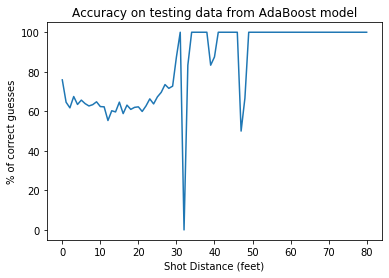

In [124]:
orgByDistance = predicDF.groupby('SHOT_DISTANCE')['correct'].mean()
attemptsByDistance = predicDF.groupby('SHOT_DISTANCE')['SHOT_MADE_FLAG'].count()

xVal = orgByDistance.index
yPer = orgByDistance.values * 100

plt.plot(xVal, yPer)
plt.xlabel('Shot Distance (feet)')
plt.ylabel('% of correct guesses')
plt.title('Accuracy on testing data from AdaBoost model')
plt.show()

In [140]:
predicDFUnder31 = predicDF[predicDF['SHOT_DISTANCE'] < 32]

for x in range(1, 40):
    predicDFUnderX = predicDF[predicDF['SHOT_DISTANCE'] < x]
    print("Under" , x, "feet", sum(predicDFUnderX['correct'])/ len(predicDFUnderX))

# accuracy now
# print(sum(predicDFUnder31['correct'])/ len(predicDFUnder31))
predicDFUnder31

Under 1 feet 0.7590014402304369
Under 2 feet 0.6994995450409464
Under 3 feet 0.6768092105263158
Under 4 feet 0.6766146993318486
Under 5 feet 0.6735480319295348
Under 6 feet 0.672462648119526
Under 7 feet 0.6704160619254959
Under 8 feet 0.6683162619403844
Under 9 feet 0.6668873441465298
Under 10 feet 0.6662058698426202
Under 11 feet 0.6647173489278753
Under 12 feet 0.6633270508878087
Under 13 feet 0.6593974175035868
Under 14 feet 0.6575659416936603
Under 15 feet 0.6554186752365649
Under 16 feet 0.6550513698630137
Under 17 feet 0.6517704517704518
Under 18 feet 0.6507421150278293
Under 19 feet 0.6485971723683247
Under 20 feet 0.6473389355742297
Under 21 feet 0.6465523086310936
Under 22 feet 0.6456808199121523
Under 23 feet 0.6450989237610363
Under 24 feet 0.6460807600950119
Under 25 feet 0.6451037613488976
Under 26 feet 0.6473511579365868
Under 27 feet 0.648792014274003
Under 28 feet 0.6496346879327635
Under 29 feet 0.6498691410896978
Under 30 feet 0.6499500879402956
Under 31 feet 0.65003

,LOC_X,LOC_Y,SHOT_DISTANCE,SHOT_MADE_PREDICTION,SHOT_MADE_FLAG,correct
17634,152.1534,209.2892,4,0,0,1
57791,25.0892,114.3058,0,1,1,1
73687,-100.5967,344.6961,6,1,1,1
29200,-90.0592,236.6517,18,1,1,1
39402,-180.2524,61.6396,18,0,0,1
...,...,...,...,...,...,...
1951,-5.3429,120.6130,12,0,0,1
5740,111.6320,60.7018,0,1,1,1
26876,-80.6238,226.8878,24,0,0,1
48856,-23.5936,174.6772,21,1,1,1


<h2> Cross validation </h2> 

First divide the data

In [65]:
# divide into equal partitions
def divide_data(df, k):
    splitFrame = np.array_split(df, k)
    return(splitFrame)

Get list of columns

In [66]:
cols = []
for x in important_features_df.columns:
    if x != "SHOT_MADE_FLAG":
        cols.append(x)

,SHOT_MADE_FLAG,SHOT_DISTANCE,LOC_Y,LOC_X,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_Backcourt,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,...,ACTION_TYPE_Step Back Bank Jump Shot,ACTION_TYPE_Step Back Jump shot,ACTION_TYPE_Tip Dunk Shot,ACTION_TYPE_Tip Layup Shot,ACTION_TYPE_Turnaround Bank Hook Shot,ACTION_TYPE_Turnaround Bank shot,ACTION_TYPE_Turnaround Fadeaway Bank Jump Shot,ACTION_TYPE_Turnaround Fadeaway shot,ACTION_TYPE_Turnaround Hook Shot,ACTION_TYPE_Turnaround Jump Shot
0,1,27,247.1845,-24.4707,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,20,46.5311,-191.5255,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,23,13.3043,225.7301,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,209.6866,165.3055,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,26,264.6146,-43.0428,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84462,0,17,131.7924,-53.7916,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
84463,0,17,3.2989,-222.2937,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
84464,1,1,69.6666,54.9737,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84465,0,9,39.1078,83.8071,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


Run the experiments

In [68]:
# run k experiments
def run_k_exp(df, k, classifier):
    
    #get split dataframe
    splitDf = divide_data(df, k)
    
    # error counter
    totalError = 0
    
    # iter counter 
    p = 0

    # rotate which one is the testing data
    while p < k:
        test = splitDf[p]
        testDF = pd.DataFrame(test)
        y_test_cv = testDF['SHOT_MADE_FLAG']
        x_test_cv = testDF.drop(columns = ['SHOT_MADE_FLAG'])
        arrWithoutTest = [m for n, m in enumerate(splitDf) if n!=p]
        
        # blank dataframe to append to 
        trainDF = pd.DataFrame(columns = cols)
        
        # make the new training frame
        for x in arrWithoutTest:
            miniDF = pd.DataFrame(x)
            trainDF = trainDF.append(miniDF, ignore_index = True)
        
        # get the x and y for training
        y_train_cv = trainDF['SHOT_MADE_FLAG']
        x_train_cv = trainDF.drop(columns = ['SHOT_MADE_FLAG'])
        
        # do modeling
        model = classifier.fit(x_train_cv, y_train_cv)
        cv_predict = model.predict(x_test_cv)
        
        # check as this takes awhile to run
        print("Predictions for %s folds, iteration %s, is done." % (k, p))
        
        # now get accuracy and error
        corr = 0
        w = 0

        while w < len(cv_predict):
            if cv_predict[w] == y_test_cv.values.ravel()[w]:
                corr += 1
            w += 1

        accCV = corr / len(cv_predict)
        errorCV = 1 - accCV
        totalError += errorCV
        
        print("Done with accuracy")
        
        p+=1
        
    avgErrCV = totalError / k
    print("Average Error for %s folds: %s" % (k, avgErrCV))
    
    return avgErrCV        

Run for a certain number of intervals

In [70]:
# do it for an interval of k
def run_for_k_interval(start_k, end_k, model, df):
    errorForAllK = 0
    
    cvCount = start_k
        
    while cvCount <= end_k:
        kError = run_k_exp(df, cvCount, model)
        errorForAllK += kError

        cvCount +=1
    
    intervalLength = end_k - start_k + 1
    return errorForAllK / (intervalLength)

Put it all together and call cross validation

In [71]:
def run_cv():
    
    error = run_for_k_interval(5, 10, AdaBoostClassifier(n_estimators = 50, random_state=4400), important_features_df)
    print("Total average error:", error)

In [72]:
run_cv()

Predictions for 5 folds, iteration 0, is done.
Done with accuracy
Predictions for 5 folds, iteration 1, is done.
Done with accuracy
Predictions for 5 folds, iteration 2, is done.
Done with accuracy
Predictions for 5 folds, iteration 3, is done.
Done with accuracy
Predictions for 5 folds, iteration 4, is done.
Done with accuracy
Average Error for 5 folds: 0.35818726339379764
Predictions for 6 folds, iteration 0, is done.
Done with accuracy
Predictions for 6 folds, iteration 1, is done.
Done with accuracy
Predictions for 6 folds, iteration 2, is done.
Done with accuracy
Predictions for 6 folds, iteration 3, is done.
Done with accuracy
Predictions for 6 folds, iteration 4, is done.
Done with accuracy
Predictions for 6 folds, iteration 5, is done.
Done with accuracy
Average Error for 6 folds: 0.35862523051016243
Predictions for 7 folds, iteration 0, is done.
Done with accuracy
Predictions for 7 folds, iteration 1, is done.
Done with accuracy
Predictions for 7 folds, iteration 2, is done.
D